In [34]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [35]:
# Load the dataset
df = pd.read_csv("../house_prices.csv")

print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape of dataset: (187531, 21)
Columns: ['Index', 'Title', 'Description', 'Amount(in rupees)', 'Price (in rupees)', 'location', 'Carpet Area', 'Status', 'Floor', 'Transaction', 'Furnishing', 'facing', 'overlooking', 'Society', 'Bathroom', 'Balcony', 'Car Parking', 'Ownership', 'Super Area', 'Dimensions', 'Plot Area']


,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,...,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,...,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN


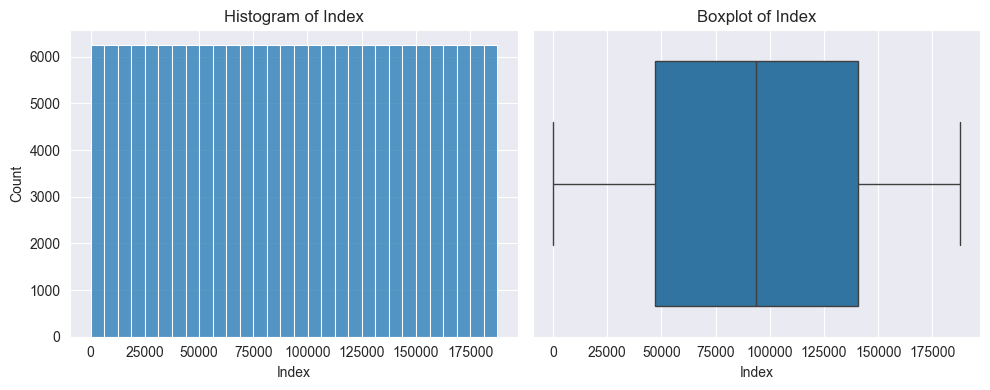

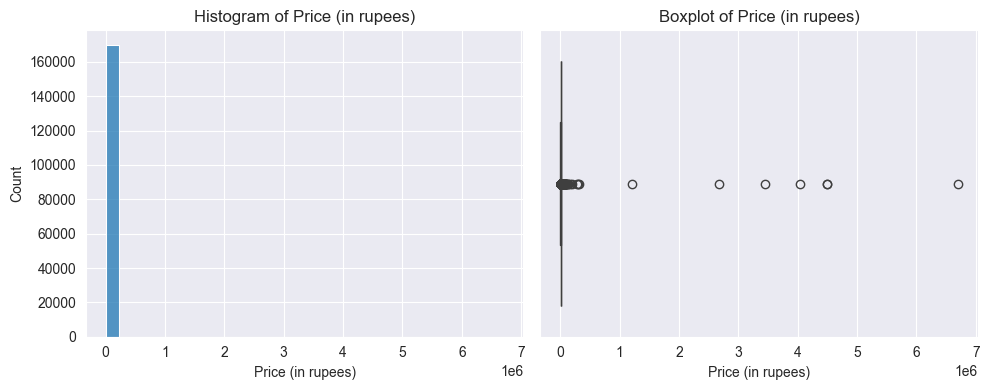

In [36]:
# For numerical columns
import warnings
warnings.filterwarnings("ignore")
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_cols:
 if df[col].notna().sum() > 0 and df[col].nunique() > 1:
        # Histogram
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=col, bins=30)
        plt.title(f'Histogram of {col}')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()


Categorical columns: ['Title', 'Description', 'Amount(in rupees)', 'location', 'Carpet Area', 'Status', 'Floor', 'Transaction', 'Furnishing', 'facing', 'overlooking', 'Society', 'Bathroom', 'Balcony', 'Car Parking', 'Ownership', 'Super Area']


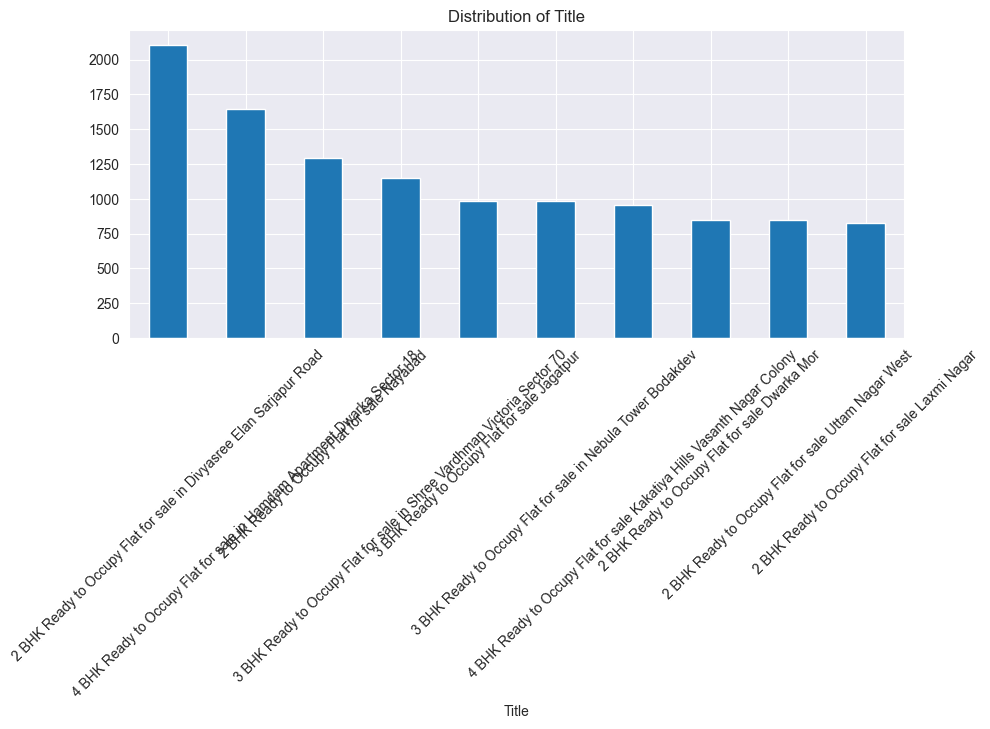

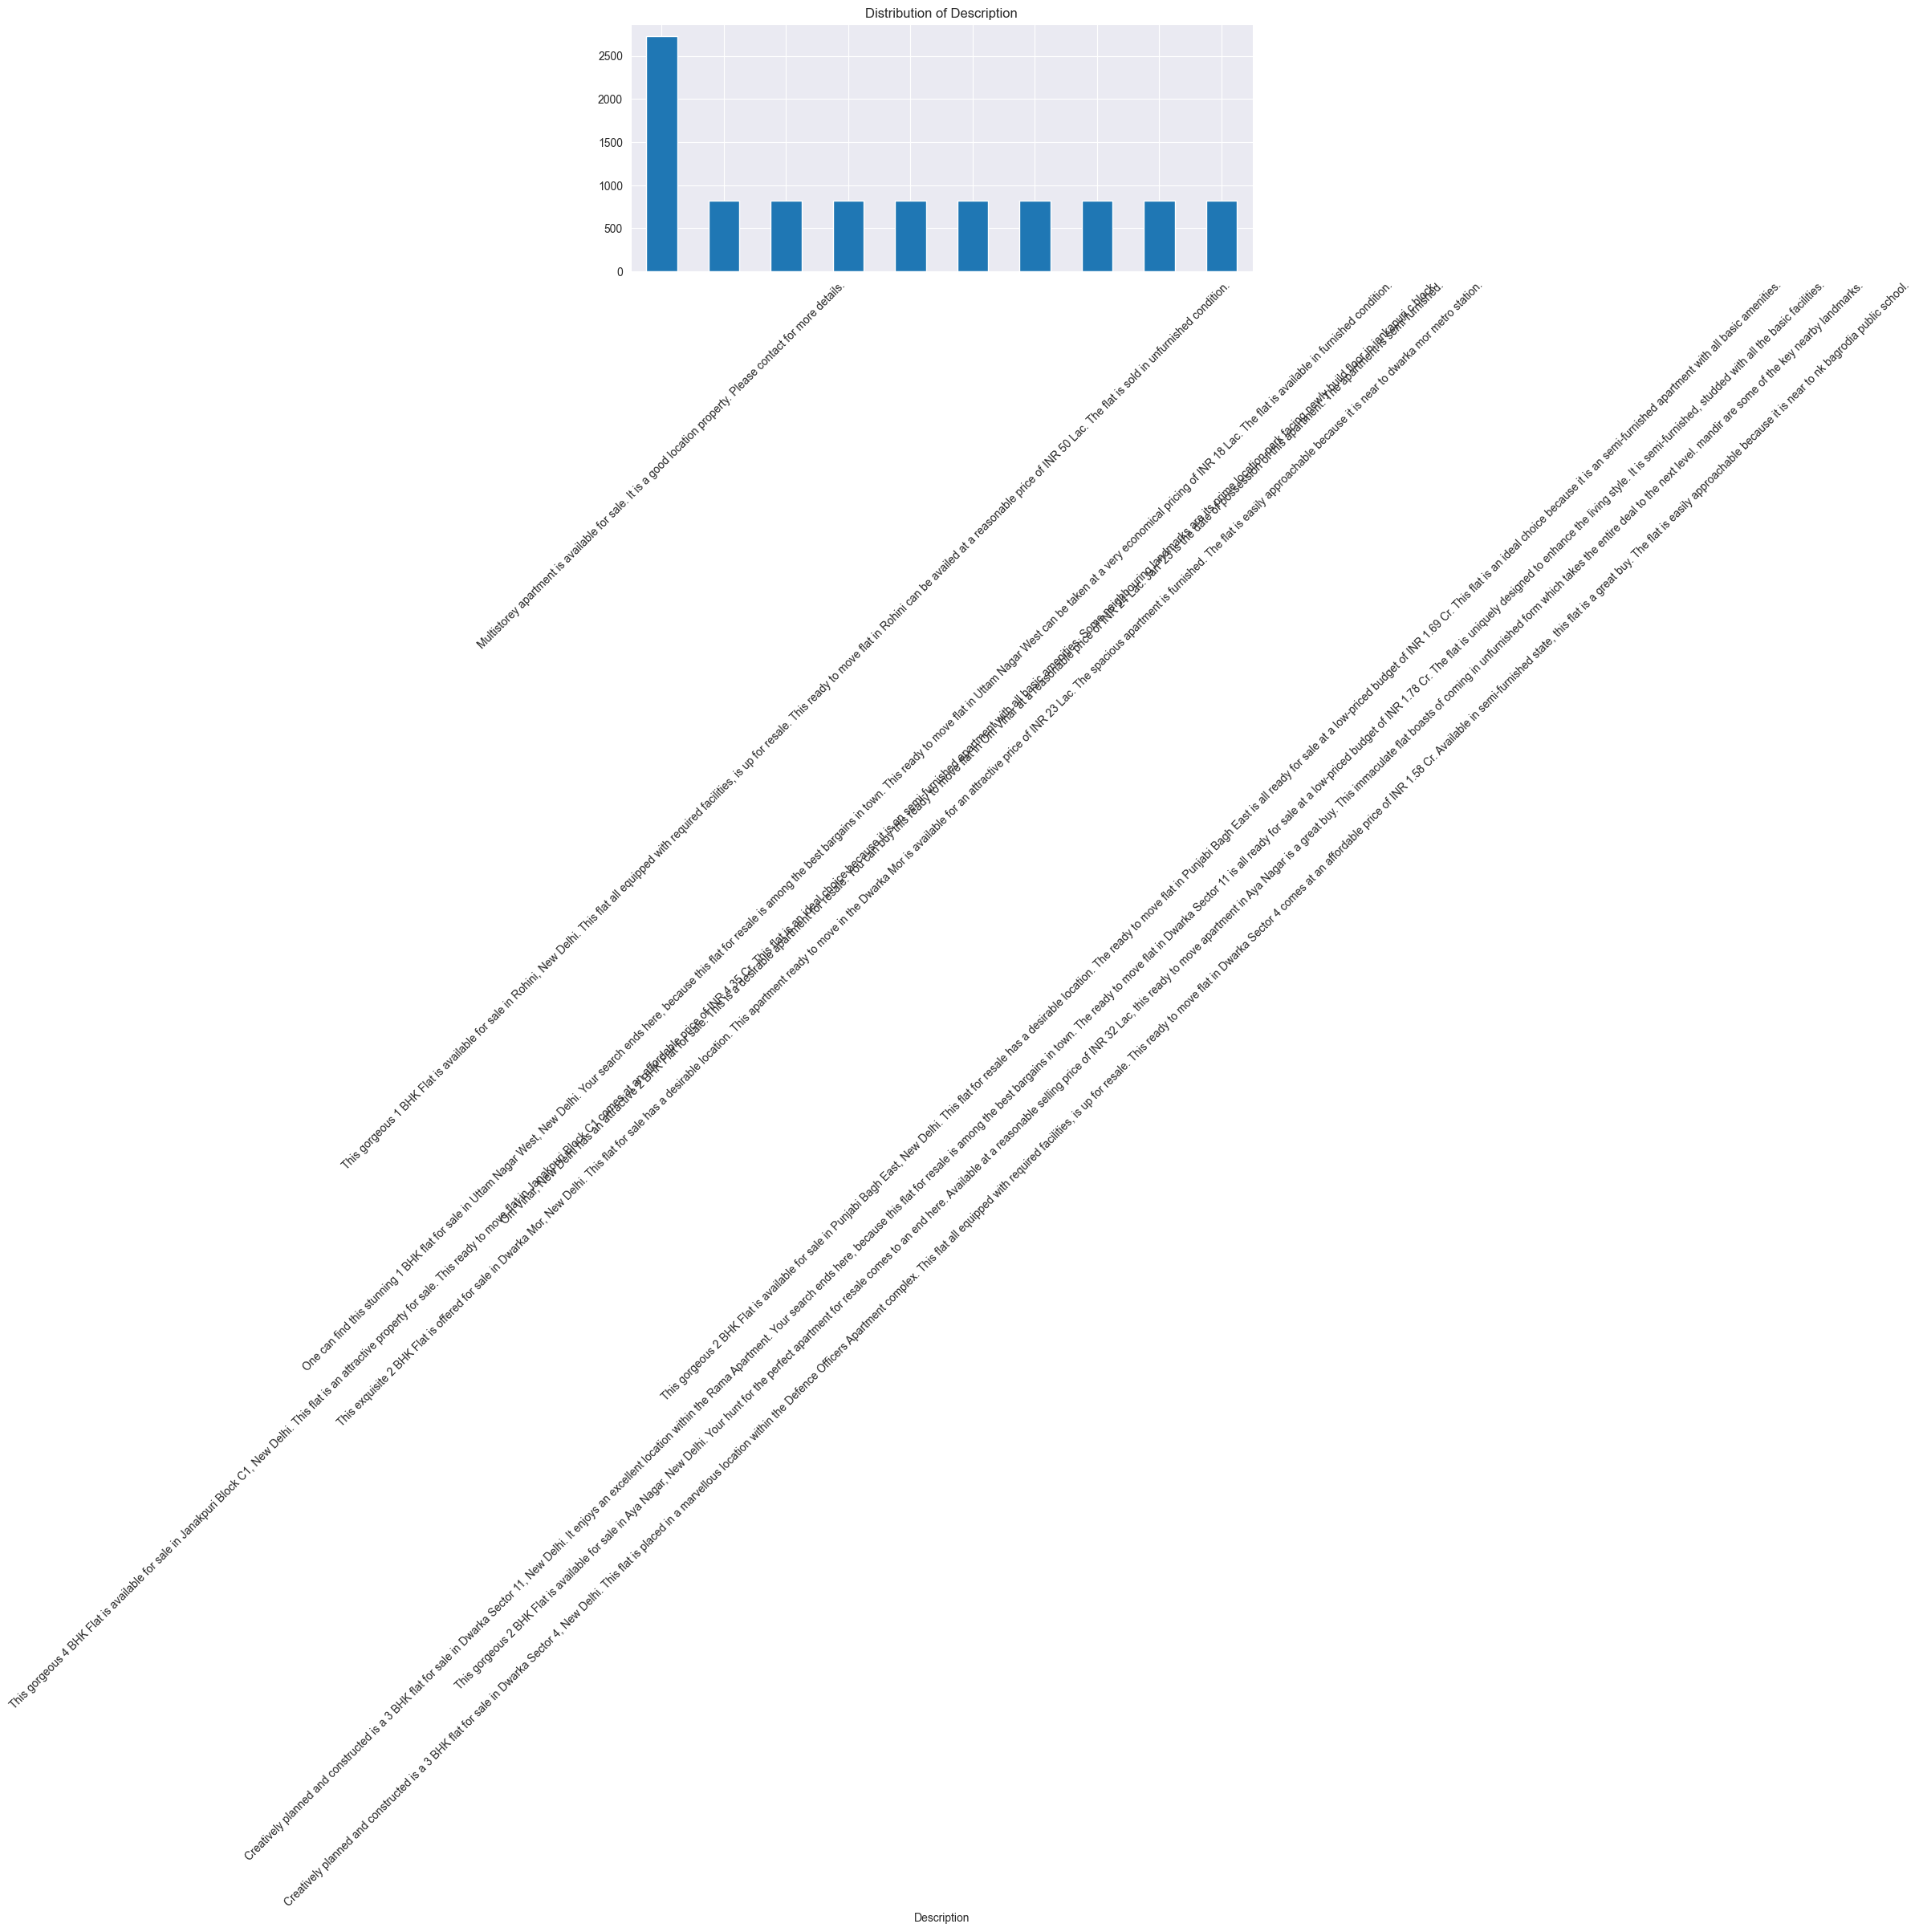

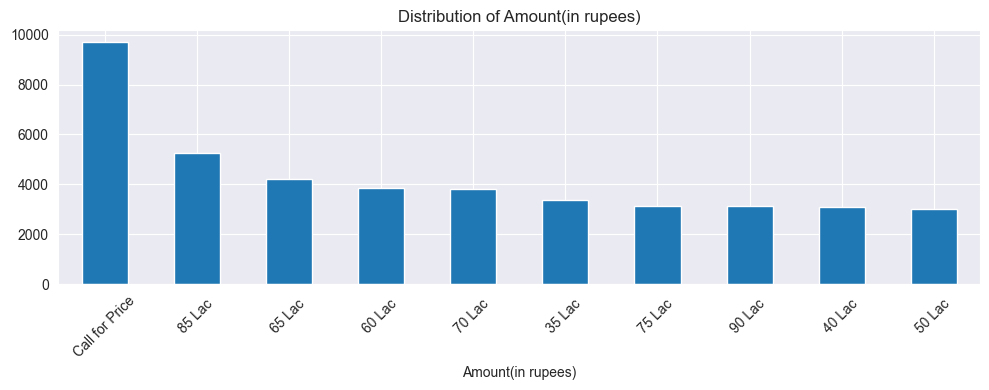

In [37]:
# For categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print(f"\nCategorical columns: {list(categorical_cols)}")

for col in categorical_cols[:3]:  # Limit to first 3 to avoid too many plots
    if df[col].notna().sum() > 0:
        plt.figure(figsize=(10, 4))
        df[col].value_counts().head(10).plot(kind='bar')  # Top 10 categories
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

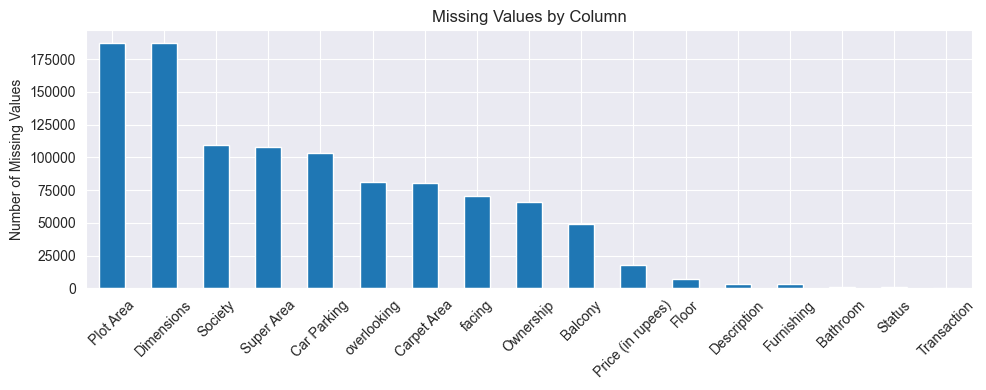

In [38]:
# Missing values summary
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    plt.figure(figsize=(10, 4))
    missing_data.sort_values(ascending=False).plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [39]:
# Drop columns that don't add predictive value
drop_cols = ['Index', 'Title', 'Description', 'Amount(in rupees)', 'Society']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

print("Remaining columns:", df.columns.tolist())
print("Shape after dropping columns:", df.shape)

Remaining columns: ['Price (in rupees)', 'location', 'Carpet Area', 'Status', 'Floor', 'Transaction', 'Furnishing', 'facing', 'overlooking', 'Bathroom', 'Balcony', 'Car Parking', 'Ownership', 'Super Area', 'Dimensions', 'Plot Area']
Shape after dropping columns: (187531, 16)


In [40]:
# Carpet Area: "500 sqft" → 500
if 'Carpet Area' in df.columns:
    df['Carpet Area'] = df['Carpet Area'].astype(str).str.replace('sqft', '', regex=False).str.strip()
    df['Carpet Area'] = pd.to_numeric(df['Carpet Area'], errors='coerce')
    print("Carpet Area converted to numeric")

# Floor: "10 out of 22" → current_floor=10, total_floors=22
if 'Floor' in df.columns:
    floor_extract = df['Floor'].astype(str).str.extract(r'(\d+)\s*out of\s*(\d+)')
    df['current_floor'] = pd.to_numeric(floor_extract[0], errors='coerce')
    df['total_floors'] = pd.to_numeric(floor_extract[1], errors='coerce')
    df = df.drop(columns=['Floor'])
    print("Floor converted to current_floor and total_floors")

# Car Parking: "1 Covered" → 1
if 'Car Parking' in df.columns:
    df['Car Parking'] = df['Car Parking'].astype(str).str.extract(r'(\d+)')
    df['Car Parking'] = pd.to_numeric(df['Car Parking'], errors='coerce')
    print("Car Parking converted to numeric")

# Bathroom, Balcony, Super Area, Dimensions, Plot Area → numeric
for col in ['Bathroom', 'Balcony', 'Super Area', 'Dimensions', 'Plot Area']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"{col} converted to numeric")

print("Shape after text-to-numeric conversion:", df.shape)
print("Data types after conversion:")
print(df.dtypes)

Carpet Area converted to numeric
Floor converted to current_floor and total_floors
Car Parking converted to numeric
Bathroom converted to numeric
Balcony converted to numeric
Super Area converted to numeric
Dimensions converted to numeric
Plot Area converted to numeric
Shape after text-to-numeric conversion: (187531, 17)
Data types after conversion:
Price (in rupees)    float64
location              object
Carpet Area          float64
Status                object
Transaction           object
Furnishing            object
facing                object
overlooking           object
Bathroom             float64
Balcony              float64
Car Parking          float64
Ownership             object
Super Area           float64
Dimensions           float64
Plot Area            float64
current_floor        float64
total_floors         float64
dtype: object


In [41]:
# Check null values in each column
print("Missing values after conversion:")
print(df.isnull().sum())

Missing values after conversion:
Price (in rupees)     17665
location                  0
Carpet Area           87103
Status                  615
Transaction              83
Furnishing             2897
facing                70233
overlooking           81436
Bathroom                863
Balcony               48957
Car Parking          103357
Ownership             65517
Super Area           187531
Dimensions           187531
Plot Area            187531
current_floor         19837
total_floors          19837
dtype: int64


In [42]:
# Handle Missing Values Safely

# Dropping columns that are 100% empty
empty_columns = []
for col in df.columns:
    if df[col].isnull().sum() == len(df[col]):
        empty_columns.append(col)

if empty_columns:
    print(f"Dropping completely empty columns: {empty_columns}")
    df = df.drop(columns=empty_columns)

# Now impute remaining columns
print("\n" + "="*50)

# Numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        print(f"Imputing numeric column '{col}'")
        df[col] = SimpleImputer(strategy="median").fit_transform(df[[col]]).ravel()

# Categorical columns  
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        print(f"Imputing categorical column '{col}'")
        df[col] = SimpleImputer(strategy="most_frequent").fit_transform(df[[col]]).ravel()

print("\n" + "="*50)
print("✅ Imputation complete!")
print("Shape after imputing nulls:", df.shape)
print("Missing values after imputation:")
print(df.isnull().sum())

Dropping completely empty columns: ['Super Area', 'Dimensions', 'Plot Area']

Imputing numeric column 'Price (in rupees)'
Imputing numeric column 'Carpet Area'
Imputing numeric column 'Bathroom'
Imputing numeric column 'Balcony'
Imputing numeric column 'Car Parking'
Imputing numeric column 'current_floor'
Imputing numeric column 'total_floors'
Imputing categorical column 'Status'
Imputing categorical column 'Transaction'
Imputing categorical column 'Furnishing'
Imputing categorical column 'facing'
Imputing categorical column 'overlooking'
Imputing categorical column 'Ownership'

✅ Imputation complete!
Shape after imputing nulls: (187531, 14)
Missing values after imputation:
Price (in rupees)    0
location             0
Carpet Area          0
Status               0
Transaction          0
Furnishing           0
facing               0
overlooking          0
Bathroom             0
Balcony              0
Car Parking          0
Ownership            0
current_floor        0
total_floors      

=== Correlation Analysis ===


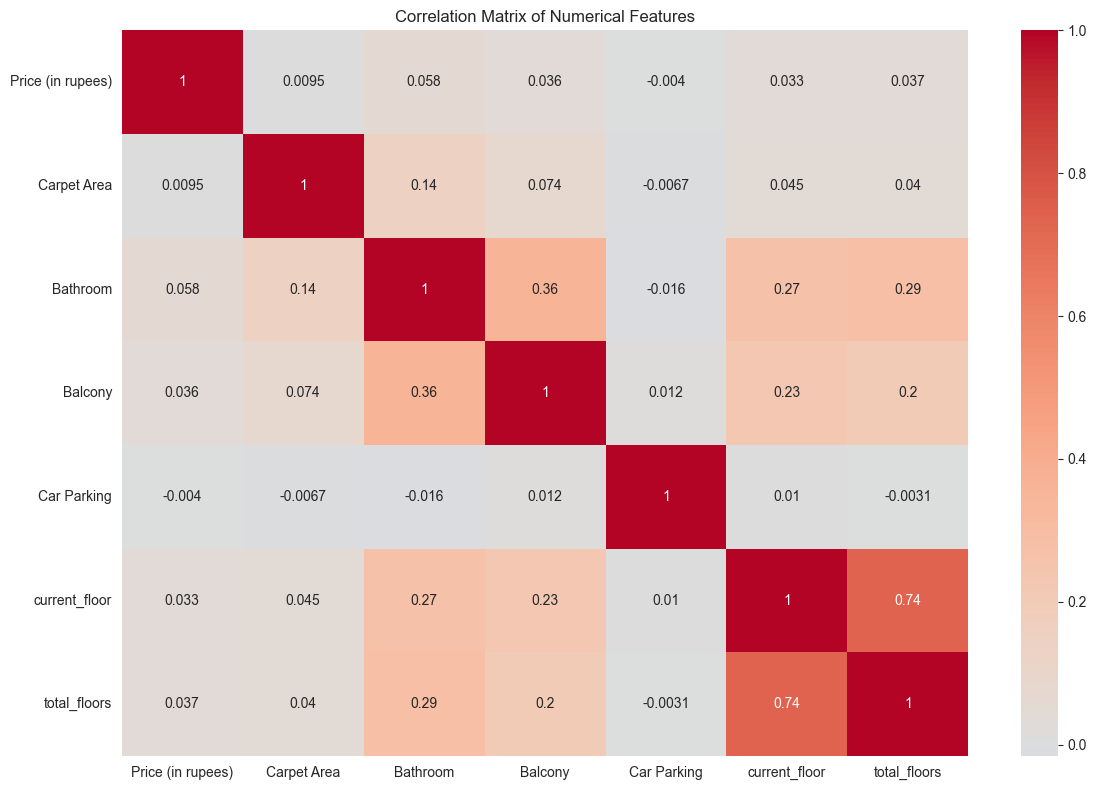

In [43]:
# Correlation heatmap
print("=== Correlation Analysis ===")
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include="number")
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [44]:
# Handle Outliers in "Price (in rupees)"
if "Price (in rupees)" in df.columns:
    Q1 = df["Price (in rupees)"].quantile(0.25)
    Q3 = df["Price (in rupees)"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Price stats - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    
    before_rows = df.shape[0]
    df = df[(df["Price (in rupees)"] >= lower_bound) & (df["Price (in rupees)"] <= upper_bound)]
    after_rows = df.shape[0]
    
    print(f"Rows before outlier removal: {before_rows}")
    print(f"Rows after outlier removal: {after_rows}")
    print(f"Rows removed: {before_rows - after_rows}")

print("Final shape after outlier removal:", df.shape)

Price stats - Q1: 4501.5, Q3: 8452.5, IQR: 3951.0
Lower bound: -1425.0, Upper bound: 14379.0
Rows before outlier removal: 187531
Rows after outlier removal: 177086
Rows removed: 10445
Final shape after outlier removal: (177086, 14)


=== Target Variable Analysis ===


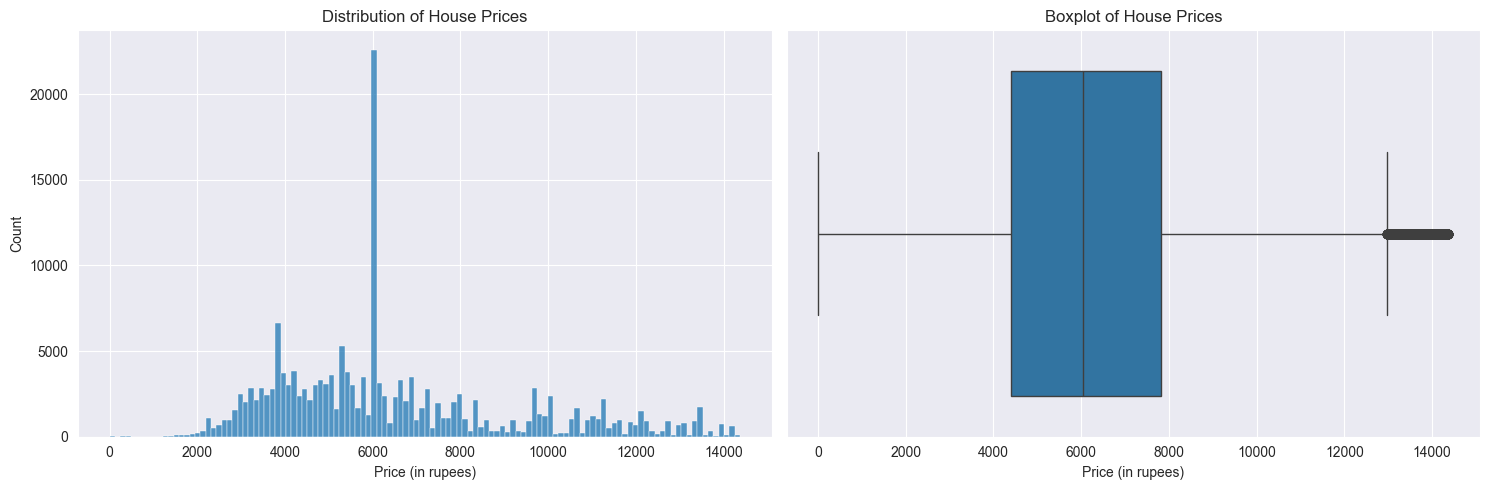

In [45]:
# Target variable distribution
print("=== Target Variable Analysis ===")
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Price (in rupees)')
plt.title('Distribution of House Prices')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Price (in rupees)')
plt.title('Boxplot of House Prices')

plt.tight_layout()
plt.show()

In [46]:
# Remove rows where target is still null (if any)
df = df.dropna(subset=['Price (in rupees)'])
print("Shape after dropping null target values:", df.shape)

# Separate features and target
X = df.drop("Price (in rupees)", axis=1)
y = df["Price (in rupees)"]

print("X shape:", X.shape)
print("y shape:", y.shape)

Shape after dropping null target values: (177086, 14)
X shape: (177086, 13)
y shape: (177086,)


In [47]:
# Numerical and Categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['Carpet Area', 'Bathroom', 'Balcony', 'Car Parking', 'current_floor', 'total_floors']
Categorical columns: ['location', 'Status', 'Transaction', 'Furnishing', 'facing', 'overlooking', 'Ownership']


In [48]:
# Pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical columns
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

print("Preprocessor created successfully")

Preprocessor created successfully


In [49]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (141668, 13) (141668,)
Testing set shape: (35418, 13) (35418,)


In [50]:
# Final data overview
print("=== PREPROCESSING COMPLETE ===")
print(f"Final dataset shape: {df.shape}")
print(f"Target variable stats:")
print(f"  Min: {y.min()}")
print(f"  Max: {y.max()}")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

=== PREPROCESSING COMPLETE ===
Final dataset shape: (177086, 14)
Target variable stats:
  Min: 0.0
  Max: 14375.0
  Mean: 6481.27
  Std: 2785.09
Training samples: 141668
Testing samples: 35418


=== Final Data Distribution ===


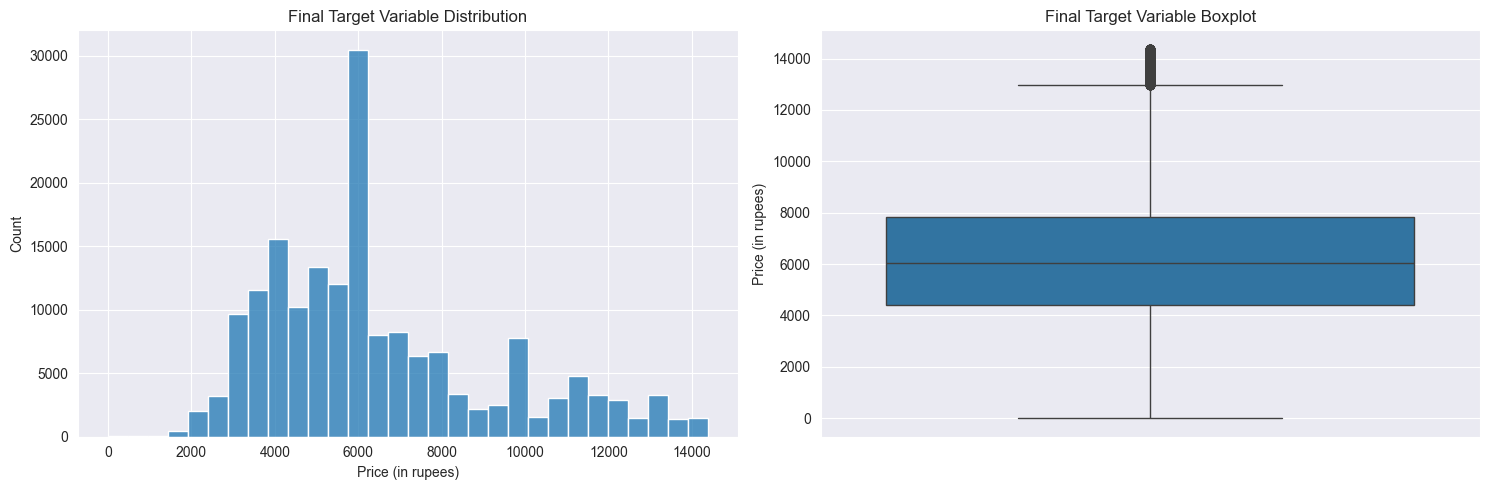

In [51]:
# FINAL DISTRIBUTION CHECK
print("=== Final Data Distribution ===")
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(y, bins=30)
plt.title('Final Target Variable Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(y)
plt.title('Final Target Variable Boxplot')

plt.tight_layout()
plt.show()

In [52]:
#Creating pre processed data file
df.to_csv('house_prices_processed.csv', index=False)
print("Preprocessed data saved as 'house_prices_processed.csv'")

# Preprocessor pipeline
import joblib
joblib.dump(preprocessor, '../models/preprocessor.pkl')

Preprocessed data saved as 'house_prices_processed.csv'


['../models/preprocessor.pkl']